In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import time
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline  
from scipy import stats

In [2]:
#데이터 불러오기
us_videos = pd.read_csv(r'C:\Users\injoo\광주 인공지능 사관학교\로테이션\자연어처리&추천시스템 김준태\미니프로젝트 데이터\USvideos.csv', error_bad_lines=False)
us_videos_json = pd.read_json(r"C:\Users\injoo\광주 인공지능 사관학교\로테이션\자연어처리&추천시스템 김준태\미니프로젝트 데이터\US_category_id.json")

b'Skipping line 2401: expected 11 fields, saw 21\nSkipping line 2800: expected 11 fields, saw 21\nSkipping line 5297: expected 11 fields, saw 12\nSkipping line 5299: expected 11 fields, saw 12\nSkipping line 5300: expected 11 fields, saw 12\nSkipping line 5301: expected 11 fields, saw 12\n'


In [1]:
us_videos.head(1)

NameError: name 'us_videos' is not defined

In [4]:
us_videos.describe()

,category_id,views,likes,dislikes,comment_total,date
count,7992.000000,7.992000e+03,7.992000e+03,7992.000000,7992.000000,7992.000000
mean,20.217718,9.390269e+05,3.449193e+04,1781.625000,4608.489740,16.094249
std,7.415525,2.148263e+06,9.136160e+04,10822.103125,20252.758016,7.677674
min,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.100000
25%,17.000000,9.686375e+04,1.907500e+03,67.000000,286.000000,11.100000
50%,23.000000,3.086115e+05,8.652500e+03,272.500000,1085.500000,16.595000
75%,25.000000,9.588758e+05,3.021350e+04,1013.000000,3462.750000,21.100000
max,43.000000,4.150067e+07,2.010366e+06,318404.000000,736179.000000,30.090000


### category_id 가 정수로 인코딩 되어있다. json 파일에서 읽어와서 딕셔너리에 "정수":"제목" 형식으로 저장하자


In [5]:
#  category_id가 뭔지 가져오는 코드
id_title_dict = {}
items_list =  us_videos_json["items"]
for i, key in enumerate(items_list):
    id_title_dict[int(key["id"])] = key["snippet"]["title"]


print(id_title_dict)

{1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 15: 'Pets & Animals', 17: 'Sports', 18: 'Short Movies', 19: 'Travel & Events', 20: 'Gaming', 21: 'Videoblogging', 22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 27: 'Education', 28: 'Science & Technology', 29: 'Nonprofits & Activism', 30: 'Movies', 31: 'Anime/Animation', 32: 'Action/Adventure', 33: 'Classics', 34: 'Comedy', 35: 'Documentary', 36: 'Drama', 37: 'Family', 38: 'Foreign', 39: 'Horror', 40: 'Sci-Fi/Fantasy', 41: 'Thriller', 42: 'Shorts', 43: 'Shows', 44: 'Trailers'}


### EDA 를 해보자!

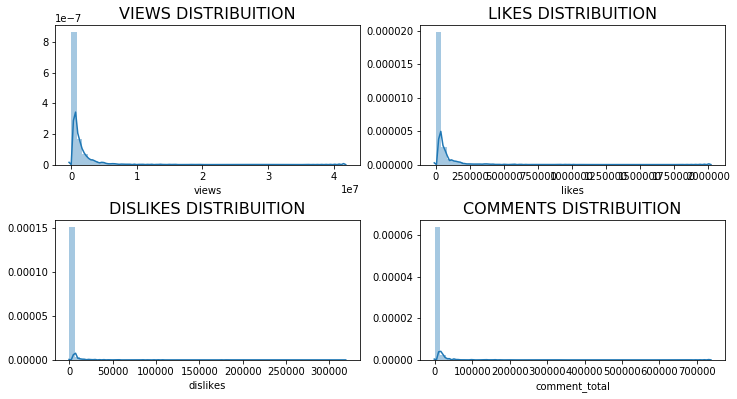

In [6]:
plt.figure(figsize = (12,6))

plt.subplot(221)
g1 = sns.distplot(us_videos['views'])
g1.set_title("VIEWS DISTRIBUITION", fontsize=16)

plt.subplot(222)
g1 = sns.distplot(us_videos['likes'])
g1.set_title("LIKES DISTRIBUITION", fontsize=16)

plt.subplot(223)
g1 = sns.distplot(us_videos['dislikes'])
g1.set_title("DISLIKES DISTRIBUITION", fontsize=16)

plt.subplot(224)
g1 = sns.distplot(us_videos['comment_total'])
g1.set_title("COMMENTS DISTRIBUITION", fontsize=16)

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 0.9)

plt.show()

### 자료가 왼쪽으로 치우쳐져 있는 분포이다 -> Log scale

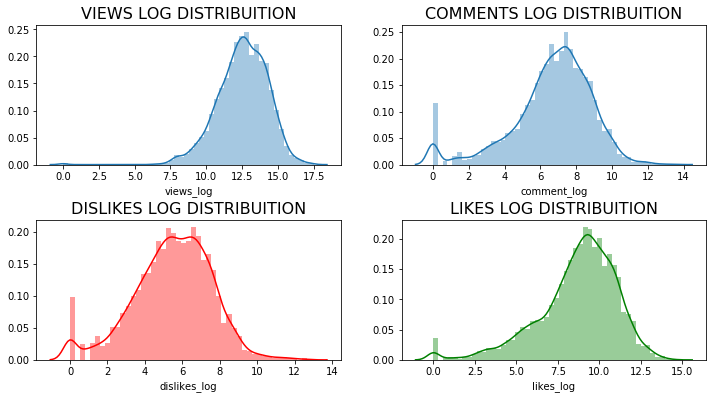

In [7]:
us_videos['likes_log'] = np.log(us_videos['likes'] + 1)
us_videos['views_log'] = np.log(us_videos['views'] + 1)
us_videos['dislikes_log'] = np.log(us_videos['dislikes'] + 1)
us_videos['comment_log'] = np.log(us_videos['comment_total'] + 1)

plt.figure(figsize = (12,6))

plt.subplot(221)
g1 = sns.distplot(us_videos['views_log'])
g1.set_title("VIEWS LOG DISTRIBUITION", fontsize=16)

plt.subplot(224)
g2 = sns.distplot(us_videos['likes_log'],color='green')
g2.set_title('LIKES LOG DISTRIBUITION', fontsize=16)

plt.subplot(223)
g3 = sns.distplot(us_videos['dislikes_log'], color='r')
g3.set_title("DISLIKES LOG DISTRIBUITION", fontsize=16)

plt.subplot(222)
g4 = sns.distplot(us_videos['comment_log'])
g4.set_title("COMMENTS LOG DISTRIBUITION", fontsize=16)

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 0.9)

plt.show()

In [8]:
print(us_videos.columns)

Index(['video_id', 'title', 'channel_title', 'category_id', 'tags', 'views',
       'likes', 'dislikes', 'comment_total', 'thumbnail_link', 'date',
       'likes_log', 'views_log', 'dislikes_log', 'comment_log'],
      dtype='object')


In [9]:
us_videos

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,date,likes_log,views_log,dislikes_log,comment_log
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,13.09,12.676245,15.295757,8.688117,10.741730
1,K4wEI5zhHB0,iPhone X — Introducing iPhone X — Apple,Apple,28,Apple|iPhone 10|iPhone Ten|iPhone|Portrait Lig...,7860119,185853,26679,0,https://i.ytimg.com/vi/K4wEI5zhHB0/default.jpg,13.09,12.132717,15.877312,10.191670,0.000000
2,cLdxuaxaQwc,My Response,PewDiePie,22,[none],5845909,576597,39774,170708,https://i.ytimg.com/vi/cLdxuaxaQwc/default.jpg,13.09,13.264901,15.581253,10.590994,12.047716
3,WYYvHb03Eog,Apple iPhone X first look,The Verge,28,apple iphone x hands on|Apple iPhone X|iPhone ...,2642103,24975,4542,12829,https://i.ytimg.com/vi/WYYvHb03Eog/default.jpg,13.09,10.125671,14.787086,8.421343,9.459541
4,sjlHnJvXdQs,iPhone X (parody),jacksfilms,23,jacksfilms|parody|parodies|iphone|iphone x|iph...,1168130,96666,568,6666,https://i.ytimg.com/vi/sjlHnJvXdQs/default.jpg,13.09,11.479027,13.970916,6.343880,8.804925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7987,xlu6i6lT_vk,How Do MASSIVE Sinkholes Form?,Life Noggin,27,sinkhole|how do sinkholes form|sinkhole in wat...,440393,14362,390,1575,https://i.ytimg.com/vi/xlu6i6lT_vk/default.jpg,22.10,9.572411,12.995425,5.968708,7.362645
7988,qRoVlH1OcI4,Trump slams Clinton for defending NFL anthem p...,Business Insider,25,Business Insider|Donald Trump|Hillary Clinton|...,55762,1265,760,1873,https://i.ytimg.com/vi/qRoVlH1OcI4/default.jpg,22.10,7.143618,10.928866,6.634633,7.535830
7989,EoejGgUNmVU,LP - Lost On You (A Night at The McKittrick Ho...,LP,10,LP|Death Valley|Other People|Lost On You|The M...,142908,7088,68,437,https://i.ytimg.com/vi/EoejGgUNmVU/default.jpg,22.10,8.866300,11.869963,4.234107,6.082219
7990,MT1CMTI0EVw,Tré Melvin @ #YouTubeBlack FanFest Washington ...,YouTube FanFest,24,YouTube FanFest|#YTFF|Washington DC|USA|YTFF|#...,24532,2148,77,0,https://i.ytimg.com/vi/MT1CMTI0EVw/default.jpg,22.10,7.672758,10.107774,4.356709,0.000000


### 불필요한 Column들은 드랍하자

In [10]:
#'title', 'channel_title', 'thumbnail_link'
us_videos = us_videos.drop(columns=[ 'title', 'channel_title', 'thumbnail_link'])

### 결측치가 있는지 확인해보자

In [11]:
us_videos.isnull().sum()

video_id         0
category_id      0
tags             0
views            0
likes            0
dislikes         0
comment_total    0
date             0
likes_log        0
views_log        0
dislikes_log     0
comment_log      0
dtype: int64

In [12]:
us_videos

,video_id,category_id,tags,views,likes,dislikes,comment_total,date,likes_log,views_log,dislikes_log,comment_log
0,XpVt6Z1Gjjo,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,12.676245,15.295757,8.688117,10.741730
1,K4wEI5zhHB0,28,Apple|iPhone 10|iPhone Ten|iPhone|Portrait Lig...,7860119,185853,26679,0,13.09,12.132717,15.877312,10.191670,0.000000
2,cLdxuaxaQwc,22,[none],5845909,576597,39774,170708,13.09,13.264901,15.581253,10.590994,12.047716
3,WYYvHb03Eog,28,apple iphone x hands on|Apple iPhone X|iPhone ...,2642103,24975,4542,12829,13.09,10.125671,14.787086,8.421343,9.459541
4,sjlHnJvXdQs,23,jacksfilms|parody|parodies|iphone|iphone x|iph...,1168130,96666,568,6666,13.09,11.479027,13.970916,6.343880,8.804925
...,...,...,...,...,...,...,...,...,...,...,...,...
7987,xlu6i6lT_vk,27,sinkhole|how do sinkholes form|sinkhole in wat...,440393,14362,390,1575,22.10,9.572411,12.995425,5.968708,7.362645
7988,qRoVlH1OcI4,25,Business Insider|Donald Trump|Hillary Clinton|...,55762,1265,760,1873,22.10,7.143618,10.928866,6.634633,7.535830
7989,EoejGgUNmVU,10,LP|Death Valley|Other People|Lost On You|The M...,142908,7088,68,437,22.10,8.866300,11.869963,4.234107,6.082219
7990,MT1CMTI0EVw,24,YouTube FanFest|#YTFF|Washington DC|USA|YTFF|#...,24532,2148,77,0,22.10,7.672758,10.107774,4.356709,0.000000


In [13]:
us_videos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7992 entries, 0 to 7991
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   video_id       7992 non-null   object 
 1   category_id    7992 non-null   int64  
 2   tags           7992 non-null   object 
 3   views          7992 non-null   int64  
 4   likes          7992 non-null   int64  
 5   dislikes       7992 non-null   int64  
 6   comment_total  7992 non-null   int64  
 7   date           7992 non-null   float64
 8   likes_log      7992 non-null   float64
 9   views_log      7992 non-null   float64
 10  dislikes_log   7992 non-null   float64
 11  comment_log    7992 non-null   float64
dtypes: float64(5), int64(5), object(2)
memory usage: 749.4+ KB


In [14]:
print(us_videos.groupby('video_id').nunique())

             video_id  category_id  tags  views  likes  dislikes  \
video_id                                                           
--JinobXWPk         1            1     1      1      1         1   
-1fzGnFwz9M         1            1     1      1      1         1   
-3AGlBYyLjo         1            1     1      1      1         1   
-3lMEZ6k5NA         1            1     1      1      1         1   
-5sCWsLlTCI         1            1     1      1      1         1   
...               ...          ...   ...    ...    ...       ...   
zqE-ultsWt0         1            1     1      5      5         5   
zrOHeEA14kQ         1            1     1      5      5         4   
zuKX0fPlo2Q         1            1     1      2      1         1   
zuUQDdWNAPc         1            1     1      2      2         2   
zyPIdeF4NFI         1            1     1      4      4         4   

             comment_total  date  likes_log  views_log  dislikes_log  \
video_id                                   

### 같은 비디오인데 시간대가 달라서 중복되어있는 비디오들도 있다. 제거 필요

In [15]:
# 우선 float64인 date의 datatype을 바꿔주자
us_videos['date'] = us_videos['date'].apply(lambda x: str(x).replace(".", "-"))
us_videos['date'] = us_videos['date'].apply(lambda x: '2017-'+str(x))


In [16]:
us_videos['date'] = pd.to_datetime(us_videos['date'], format='%Y-%d-%m')
us_videos['date']

0      2017-09-13
1      2017-09-13
2      2017-09-13
3      2017-09-13
4      2017-09-13
          ...    
7987   2017-01-22
7988   2017-01-22
7989   2017-01-22
7990   2017-01-22
7991   2017-01-22
Name: date, Length: 7992, dtype: datetime64[ns]

In [33]:
# sorted = us_videos.sort_index(by='date')
# video_id별로 가장 마지막꺼만 가져오자 
result = us_videos.drop_duplicates('video_id', keep='last').values
duplicates_removed = pd.DataFrame(result, columns = us_videos.columns)

In [39]:
duplicates_removed.head(3)

,video_id,category_id,tags,views,likes,dislikes,comment_total,date,likes_log,views_log,dislikes_log,comment_log
0,5ywKal6-anc,24,TMZ2016FS11221|TMZ|Hollywood|Celebrity|Enterta...,703750,2921,2196,1042,2017-09-13,7.98002,13.4642,7.69485,6.94986
1,GGm0FQ6i74U,25,vox.com|vox|explain|ezra klein|hillary clinton...,244433,9143,6826,4838,2017-09-13,9.12085,12.4067,8.82864,8.48446
2,qJJHhVf3_ZM,24,James Corden|The Late Late Show|Colbert|late n...,220661,2070,449,352,2017-09-13,7.63579,12.3044,6.10925,5.86647


In [35]:
# #정리된 데이터셋 저장
duplicates_removed.to_csv(r'./\cleaned_USvidoes.csv', )

In [36]:
cleaned_USvideos = duplicates_removed

In [37]:
cleaned_USvideos

,video_id,category_id,tags,views,likes,dislikes,comment_total,date,likes_log,views_log,dislikes_log,comment_log
0,5ywKal6-anc,24,TMZ2016FS11221|TMZ|Hollywood|Celebrity|Enterta...,703750,2921,2196,1042,2017-09-13,7.98002,13.4642,7.69485,6.94986
1,GGm0FQ6i74U,25,vox.com|vox|explain|ezra klein|hillary clinton...,244433,9143,6826,4838,2017-09-13,9.12085,12.4067,8.82864,8.48446
2,qJJHhVf3_ZM,24,James Corden|The Late Late Show|Colbert|late n...,220661,2070,449,352,2017-09-13,7.63579,12.3044,6.10925,5.86647
3,9CILSvf1snQ,26,cupcakes|how to make vanilla cupcakes|over the...,27794,1692,34,174,2017-09-13,7.43426,10.2326,3.55535,5.16479
4,k9bYO7uSnrg,28,iphone x|apple iphone|face id|apple|hardware|h...,14577,160,19,51,2017-09-13,5.0814,9.58727,2.99573,3.95124
...,...,...,...,...,...,...,...,...,...,...,...,...
2359,xlu6i6lT_vk,27,sinkhole|how do sinkholes form|sinkhole in wat...,440393,14362,390,1575,2017-01-22,9.57241,12.9954,5.96871,7.36265
2360,qRoVlH1OcI4,25,Business Insider|Donald Trump|Hillary Clinton|...,55762,1265,760,1873,2017-01-22,7.14362,10.9289,6.63463,7.53583
2361,EoejGgUNmVU,10,LP|Death Valley|Other People|Lost On You|The M...,142908,7088,68,437,2017-01-22,8.8663,11.87,4.23411,6.08222
2362,MT1CMTI0EVw,24,YouTube FanFest|#YTFF|Washington DC|USA|YTFF|#...,24532,2148,77,0,2017-01-22,7.67276,10.1078,4.35671,0


NameError: name 'youtube' is not defined